# Movie Sentiment Classifier
### Sentiment analysis can be considered a binary classification problem. The input is natural language text, and the output is a binary decision that infers positive or negative sentiment.

## Useful Resources


# Data
#### Data taken from Bag of Words meet Popcorn challenge from Kaggle
#### Tika python library used for parsing html raw text
#### Other natural language processing libraries for data wrangling
#### TQDM added for the progress Bar

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.compat.v1 as tfv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from tika import parser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve,auc
from tqdm.notebook import tqdm

In [2]:
from nltk.corpus import stopwords
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/harshpareek/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/harshpareek/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/harshpareek/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/harshpareek/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/harshpareek/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/harshpareek/nltk_data...
[nltk_data]    |   Pa

True

# Raw Data

In [3]:
train = pd.read_csv(
    "labeledTrainData.tsv",
    delimiter='\t',
    quoting=3
)

In [4]:
print("shape of the data: ",train.shape)

shape of the data:  (25000, 3)


In [5]:
print("column names in the training Data: ",train.columns.values)

column names in the training Data:  ['id' 'sentiment' 'review']


In [6]:
print("data sample: ")
train.head()

data sample: 


,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


## Let us see how parser will work for us:

In [7]:
print("Raw review sample from teh training Data: ")
print(train.loc[0,"review"])

Raw review sample from teh training Data: 
"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The 

In [8]:
parsed = parser.from_buffer("<html>" + train.loc[0,"review"] + "</html>")
print("parsed sample Data: ")
print(parsed["content"])

parsed sample Data: 








"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.

Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.

The actual feature film bit when it fi

## Parsing function

In [9]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = parser.from_buffer( "<html>" + raw_review + "</html>" )["content"]
    #
    # 2. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))
    #
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]
    #
    # 6. Join the words back into one string separated by space,
    # and return the result.
    return( " ".join( meaningful_words ))

In [10]:
num_reviews = train["review"].size

print("number of reviews: ",num_reviews)

number of reviews:  25000


In [11]:
cleaned_train_reviews = []

In [12]:
for i in tqdm(range(0,num_reviews)):
    cleaned_train_reviews.append(review_to_words(train["review"][i]))

  0%|          | 0/25000 [00:00<?, ?it/s]

In [13]:
# confirming the data
print(cleaned_train_reviews[100])

uk edition show rather less extravagant us version person concerned get new kitchen perhaps bedroom bathroom wonderfully grateful got us version show everything reality tv instead making improvements house occupants could afford entire house gets rebuilt know show trying show lousy welfare system exists us beg hard enough receive rather vulgar product placement takes place particularly sears also uncalled rsther turning one family deprived area potential millionaires would far better help community whole instead spending hundreds thousands dollars one home build something whole community perhaps place diy power tools borrowed returned along building materials everyone benefit want giving one person cause enormous resentment among rest local community still live run houses


## And finally, BAG OF WORDS IS MEETING POPCORN

In [14]:
vectorizer = CountVectorizer(
    analyzer="word",
    tokenizer=None,
    stop_words=None,
    max_features=5000,
    preprocessor=None
)

In [15]:
train_data_features = vectorizer.fit_transform(cleaned_train_reviews)

In [16]:
train_data_features = train_data_features.toarray()

In [18]:
print("our train_features dataset has shape: ",train_data_features.shape)

our train_features dataset has shape:  (25000, 5000)


In [20]:
# let's look at the words in the vocabulary generated by our fav vectorizer
vocab = vectorizer.get_feature_names()
print("size of vocabulary: %d" %(len(vocab)))

size of vocabulary: 5000


In [22]:
print("words are: %s" %vocab)

words are: ['abandoned', 'abc', 'abilities', 'ability', 'able', 'abraham', 'absence', 'absent', 'absolute', 'absolutely', 'absurd', 'abuse', 'abusive', 'abysmal', 'academy', 'accent', 'accents', 'accept', 'acceptable', 'accepted', 'access', 'accident', 'accidentally', 'accompanied', 'accomplished', 'according', 'account', 'accuracy', 'accurate', 'accused', 'achieve', 'achieved', 'achievement', 'acid', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'activities', 'actor', 'actors', 'actress', 'actresses', 'acts', 'actual', 'actually', 'ad', 'adam', 'adams', 'adaptation', 'adaptations', 'adapted', 'add', 'added', 'adding', 'addition', 'adds', 'adequate', 'admire', 'admit', 'admittedly', 'adorable', 'adult', 'adults', 'advance', 'advanced', 'advantage', 'adventure', 'adventures', 'advertising', 'advice', 'advise', 'affair', 'affect', 'affected', 'afford', 'aforementioned', 'afraid', 'africa', 'african', 'afternoon', 'afterwards', 'age', 'aged', 'agent', 'agents', 'ages', 'aging',

In [23]:
# Generating frequencies
dist = np.sum(train_data_features,axis=0)

for tag,count in zip(vocab,dist):
    print("%s -> %d" % (tag,count))

abandoned -> 187
abc -> 125
abilities -> 108
ability -> 454
able -> 1259
abraham -> 85
absence -> 116
absent -> 83
absolute -> 352
absolutely -> 1485
absurd -> 306
abuse -> 192
abusive -> 91
abysmal -> 98
academy -> 297
accent -> 485
accents -> 203
accept -> 300
acceptable -> 130
accepted -> 144
access -> 92
accident -> 318
accidentally -> 200
accompanied -> 88
accomplished -> 124
according -> 296
account -> 186
accuracy -> 81
accurate -> 284
accused -> 123
achieve -> 179
achieved -> 139
achievement -> 124
acid -> 90
across -> 971
act -> 1251
acted -> 660
acting -> 6494
action -> 3355
actions -> 311
activities -> 83
actor -> 2389
actors -> 4488
actress -> 1219
actresses -> 369
acts -> 394
actual -> 793
actually -> 4240
ad -> 148
adam -> 303
adams -> 98
adaptation -> 454
adaptations -> 80
adapted -> 154
add -> 810
added -> 440
adding -> 166
addition -> 347
adds -> 337
adequate -> 113
admire -> 124
admit -> 621
admittedly -> 134
adorable -> 101
adult -> 511
adults -> 376
advance -> 101
a

## A very cute Exploratory Data Analysis

In [36]:
initialIndex = 0
finalIndex = 100

In [37]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

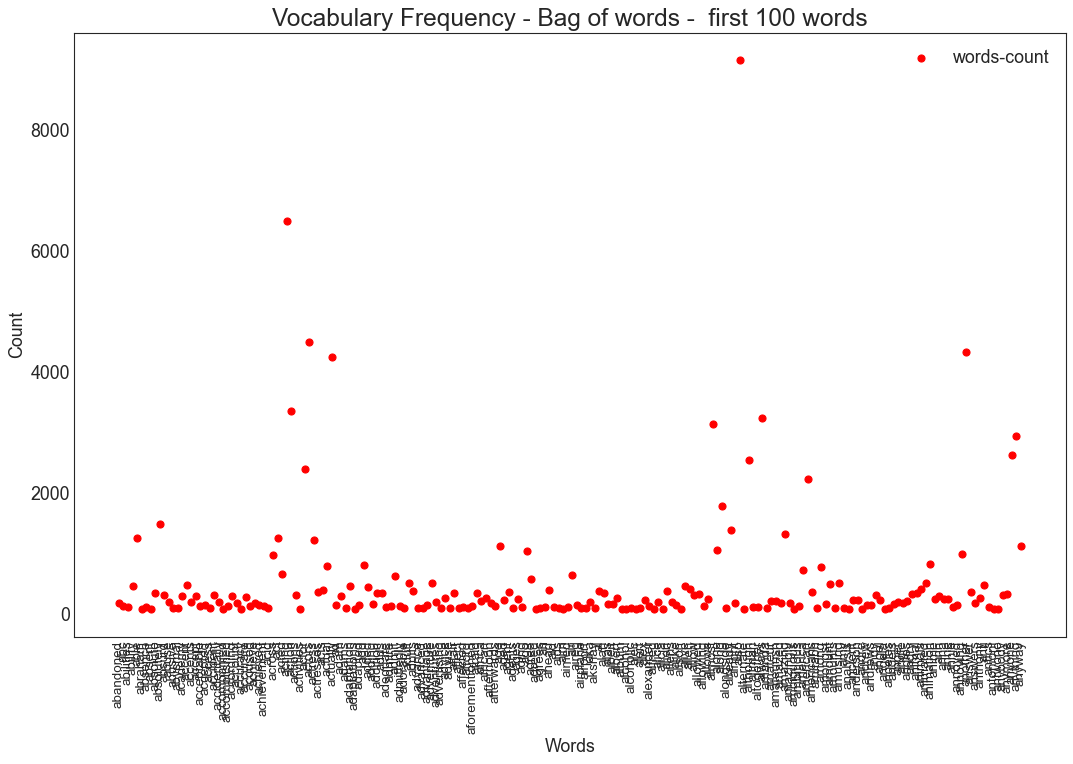

In [39]:
plt.figure(figsize=(16,10),dpi=80,facecolor="w",edgecolor="k")

plt.scatter(vocab[initialIndex:finalIndex],dist[initialIndex:finalIndex], s = 40, c = 'r', label = "words-count")

plt.gca().set(xlabel = "Words", ylabel = "Count")

plt.xticks(vocab[initialIndex:finalIndex],fontsize=12,rotation = "vertical")
plt.yticks(fontsize=med)
plt.title("Vocabulary Frequency - Bag of words -  first 100 words", fontsize = large)
plt.legend(fontsize=med)
plt.show()

# MODEL

In [30]:
learning_rate = 0.1
training_epochs = 2000

In [31]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [33]:
tfv.disable_eager_execution()
Y = tfv.placeholder(
    tf.float32,
    shape=(None,),
    name = "y"
)

In [41]:
w = tf.Variable(
    [0.] * ((train_data_features.shape[1]) + 1),
    name="w",
    trainable=True
)
print("shape of variable: ",w.shape)

shape of variable:  (5001,)


In [42]:
ys = train['sentiment'].values

In [46]:
print("label shape: ",ys.shape)

label shape:  (25000,)


In [47]:
Xs = {}
for i in range(train_data_features.shape[1]):
    Xs["X" + str(i)] = tfv.placeholder(
        tf.float32,shape = (None,), name = "x" + str(i)
    )

In [48]:
linear = w[0]
for i in range(0, train_data_features.shape[1]):
    linear = linear + (w[i+1] * Xs["X"+str(i)])
y_model = tf.sigmoid(linear)

In [49]:
cost = tf.reduce_mean(
    -tfv.log(y_model * Y + (1-y_model) * (1-Y))
)

In [50]:
train_op = tfv.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [ ]:
saver = tfv.train.Saver()
with tfv.Session() as sess:
    sess.run(tfv.global_variables_initializer())
    prev_err = 0
    for epoch in tqdm(range(training_epochs)):
        feed_dict = {}
        for i in range(train_data_features.shape[1]):
            feed_dict[Xs["X"+str(i)]] = train_data_features[:, i, None].reshape(len(train_data_features))
        feed_dict[Y] = ys

        err,_ = sess.run(
            [cost,train_op],
            feed_dict=feed_dict
        )
        print(epoch,err)
        if abs(prev_err - err) < 0.0001:
            break
        prev_err = err

    w_val = sess.run(w,feed_dict=feed_dict)

  0%|          | 0/2000 [00:00<?, ?it/s]

0 0.6931475
1 0.68367267
2 0.67517424
3 0.6673778
4 0.6601467
5 0.6533885
6 0.6470342
7 0.64103085
8 0.6353369
9 0.62991923
10 0.62475115
11 0.61981046
12 0.61507845
13 0.6105392
14 0.6061786
15 0.60198456
16 0.59794647
17 0.59405416
18 0.5902991
19 0.58667326
20 0.5831694
21 0.5797805
22 0.5765007
23 0.5733241
24 0.57024544
25 0.5672598
26 0.5643625
27 0.56154937
28 0.5588163
29 0.55615956
30 0.55357563
31 0.5510613
32 0.5486133
33 0.5462289
34 0.5439053
35 0.54163975
36 0.5394302
37 0.537274
38 0.5351691
39 0.5331134
40 0.53110516
41 0.5291423
42 0.52722317
43 0.52534604
44 0.5235097
45 0.5217122
46 0.51995236
47 0.51822865
48 0.51654017
49 0.5148854
50 0.5132632
51 0.51167256
52 0.51011235
53 0.5085817
54 0.5070795
55 0.5056047
56 0.50415677
57 0.50273484
58 0.5013377
59 0.49996504
60 0.4986159
61 0.4972896
62 0.49598548
63 0.49470282
64 0.49344105
65 0.49219966
66 0.4909781
67 0.48977554
68 0.48859173
69 0.48742592
70 0.48627788
71 0.48514703
72 0.48403296
73 0.48293504
74 0.481853

TypeError: save() missing 1 required positional argument: 'save_path'

In [64]:
w_val

array([ 0.00287739, -0.00082148,  0.01867105, ..., -0.02059074,
       -0.07866896, -0.0044847 ], dtype=float32)

In [65]:
print("max weight: ", np.max(w_val))

max weight:  0.4994014


# Now we will predict

In [75]:
def predict(test_review, vocab, weights, threshold=0.5):
    #clean the review
    test_review_c = review_to_words(test_review)

    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",
                                   tokenizer = None,
                                   preprocessor = None,
                                   stop_words = None,
                                   max_features = 5000)
    ex_data_features = n_vectorizer.fit_transform([test_review_c])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])

    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]

    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]

    # our log reg model
    test_linear = weights[0]
    for i in range(0, train_data_features.shape[1]):
        test_linear = test_linear + (weights[i+1] * test_feature_vec[i])
    y_test = sigmoid(test_linear)

    # here it is the prediction
    return np.greater(y_test, threshold).astype(float)

In [ ]:
test = pd.read_csv(
    "testData.tsv",
    header=0,
    delimiter="\t",
    quoting=3
)

# Let's do some TestING

In [70]:
print("Test Data Shape: ", test.shape)

Test Data Shape:  (25000, 2)


In [71]:
#try it out on new data
new_neg_review = "Man, this movie really sucked. It was terrible. I could not possibly watch this movie again!"
new_pos_review = "I think that this is a fantastic movie, it really "

In [73]:
new_neg_review_c = review_to_words(new_neg_review)
new_pos_review_c = review_to_words(new_pos_review)
print("positive one: ", new_neg_review_c)
print("negative one: ",new_pos_review_c)

positive one:  man movie really sucked terrible could possibly watch movie
negative one:  think fantastic movie really


In [77]:
result_first = predict(
    new_neg_review,vocab,w_val
)
print("outcome: ",result_first)

outcome:  0.0


In [78]:
result_sec = predict(
    new_pos_review,vocab,w_val
)
print("outcome: ",result_sec)

outcome:  1.0


In [79]:
num_reviews = len(test["review"])
result = []
for i in tqdm(range(0, num_reviews)):
    r = predict(test["review"][i], vocab,w_val)
    result.append(r)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [80]:
output = pd.DataFrame(
    data = {
        "id": test["id"],
        "sentiment": result
    }
)

In [83]:
output.to_csv("./popcorn.csv", index=False,quoting=3)

### And we have tested our model on testdata aswell and model output is saved in another file name popcorn.csv

In [84]:
print("thanks")

thanks
